<a href="https://colab.research.google.com/github/Cipe96/EEG-Recognition/blob/main/Classificatore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6>**EEG Recognition: Classificatore**</font>
</br><font size=3>*Marco Cipollina, Riccardo Era*</font>


<p style="font-size:4px;" align="justify">In questo notebook viene svolta l'analisi del dataset composto dalla sola prima run del famoso "EEG Motor Movement/Imagery". È possibile trovare informazioni dettagliate riguardo il dataset originale al seguente <a href="https://physionet.org/content/eegmmidb/1.0.0/">link</a>.</p>
<p style="font-size:4px;" align="justify">Oltre che poter osservare gli elementi principali, è possibile svolgere delle analisi specifiche a relativi campioni e volontari.</p>

<font size=4>**Indice:**</font>
*   [Import librerie](#1)
*   [Downloads](#2)
*   [Classificatore](#3)

<a name="1"></a>
# **Import librerie**

Iniziamo installando la libreria MNE, essenziale per l'analisi di dati EEG grazie alla sua gestione di file in formato EDF.

In [ ]:
%%capture
# evita l' output a video
!pip install mne

Importiamo le librerie e montiamo Google Drive per garantire l'accesso agli altri file.

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import drive
import pandas as pd
import numpy as np
import json
import sys
import mne
import os

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


<a name="2"></a>
# **Download**

In [ ]:
#@title Percorso della cartella del progetto su Google Drive:

#@markdown Se la cartella del progetto si trova nella root di Drive, scrivere solo il suo nome:
PERCORSO_DRIVE = "EEG Recognition" #@param {type:"string"}

PERCORSO_DRIVE = '/content/drive/MyDrive/' + PERCORSO_DRIVE

In [ ]:
sys.path.append(PERCORSO_DRIVE)                       # ci permetterà di importare le funzioni presenti in altri file
from shared_utilities import download_dataset

Scarichiamo dal file "EEG_Motor_Movement-Imagery_R01_ID.json" l'ID necessario per il download del dataset.

In [ ]:
with open(PERCORSO_DRIVE + '/EEG_Motor_Movement-Imagery_R01_ID.json', 'r') as file:
  config = json.load(file)

DATASET_ID = config['DATASET_ID']

In [ ]:
#@title Impostazioni download

#@markdown Nome del zip dataset post download:
DATASET_NAME = 'EEG_Motor_Movement-Imagery.zip' #@param {type:"string"}

download_dataset(DATASET_ID, DATASET_NAME, msg=True)

Downloading...
From (original): https://drive.google.com/uc?id=1WwuAh25Jfx-I8rY3vFGyXiI79YfLYUpH
From (redirected): https://drive.google.com/uc?id=1WwuAh25Jfx-I8rY3vFGyXiI79YfLYUpH&confirm=t&uuid=6e88ffc4-dd26-483b-9109-a60b460016cf
To: /content/EEG_Motor_Movement-Imagery.zip
100%|██████████| 76.6M/76.6M [00:05<00:00, 13.6MB/s]



File scaricato e salvato come EEG_Motor_Movement-Imagery.zip!



Dopo aver scaricato il dataset lo unzippiamo ed eliminiamo i file txt e la cartella sample_data creata automaticamente da Colab.

In [ ]:
%%capture

! unzip "{DATASET_NAME}"              # unzippa il file zip
! rm /content/AMSL/*.txt              # elimina i file txt
! rm -r /content/sample_data          # elimina la cartella di default di Colab

<a name="3"></a>
# **Classificatore**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Supponiamo che train_array, val_array, test_array, label_tr, label_val, label_ts siano già definiti come array numpy
# Converti le etichette in one-hot encoding
num_classes = len(np.unique(label_tr))
print("Numero di classi:", num_classes)
y_train = tf.keras.utils.to_categorical(label_tr, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(label_val, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(label_ts, num_classes=num_classes)

# Trasponi i dati per renderli compatibili con LSTM
train_array = train_array.transpose(0, 2, 1)  # Diventa (num_segments, 240, 64)
val_array = val_array.transpose(0, 2, 1)
test_array = test_array.transpose(0, 2, 1)

# Calcola la media e la deviazione standard sul training set dopo la trasposizione
mean = train_array.mean(axis=(0, 1), keepdims=True)  # Media calcolata sui segmenti e sui campioni temporali per ogni canale
std = train_array.std(axis=(0, 1), keepdims=True)    # Deviazione standard calcolata sui segmenti e campioni temporali per ogni canale

# Normalizza il training set
train_array = (train_array - mean) / std

# Applica la stessa normalizzazione a validation e test set
val_array = (val_array - mean) / std
test_array = (test_array - mean) / std


Numero di classi: 109


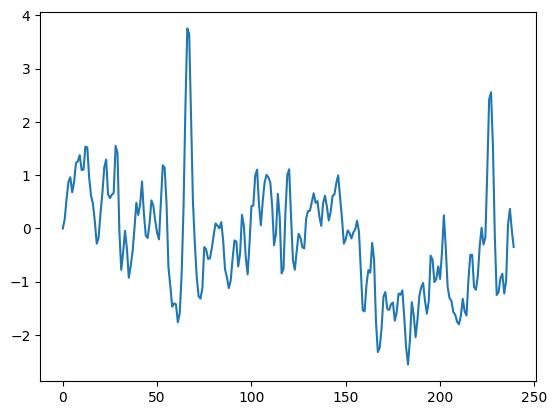

In [ ]:
plt.plot(train_array[0,:,63])
plt.show()

In [ ]:
print(train_array.shape)

print(val_array.shape)

print(test_array.shape)

print(label_tr.shape)
print(label_val.shape)
print(label_ts.shape)
print(rec.shape)

(3052, 240, 64)
(654, 240, 64)
(654, 240, 64)
(3052,)
(654,)
(654,)
(64, 9600)


In [ ]:
# Definisci il modello
model = Sequential()
model.add(LSTM(256, input_shape=(train_array.shape[1], train_array.shape[2]), return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compila il modello
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Addestra il modello
model.fit(train_array, y_train, epochs=100, batch_size=32, validation_data=(val_array, y_val))

# Valuta il modello
loss, accuracy = model.evaluate(test_array, y_test, verbose=0)
print(f'Accuratezza sul test: {accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.0106 - loss: 4.7118 - val_accuracy: 0.0352 - val_loss: 4.5713
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0430 - loss: 4.4666 - val_accuracy: 0.0505 - val_loss: 4.3463
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0863 - loss: 4.1702 - val_accuracy: 0.0749 - val_loss: 3.9496
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.1087 - loss: 3.8784 - val_accuracy: 0.0841 - val_loss: 3.8500
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1409 - loss: 3.5888 - val_accuracy: 0.0933 - val_loss: 3.6783
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1778 - loss: 3.3672 - val_accuracy: 0.1361 - val_loss: 3.5804
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1999 - loss: 3.2458 - val_accuracy: 0.1590 - val_loss: 3.4363
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2513 - loss: 3.0283 - val_accuracy: 0.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten
# Definisci il modello
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(train_array.shape[1], train_array.shape[2])))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compila il modello
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Addestra il modello
model.fit(train_array, y_train, epochs=100, batch_size=32, validation_data=(val_array, y_val))

# Valuta il modello
loss, accuracy = model.evaluate(test_array, y_test, verbose=0)
print(f'Accuratezza sul test: {accuracy:.4f}')

Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.0351 - loss: 4.6190 - val_accuracy: 0.0917 - val_loss: 4.2284
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1764 - loss: 3.7143 - val_accuracy: 0.1483 - val_loss: 4.0178
Epoch 3/100
17/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3819 - loss: 2.6175 

KeyboardInterrupt: 